# Synthetic data test: Model with multiple sources and moving window scheme

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

Number of data: 3111


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


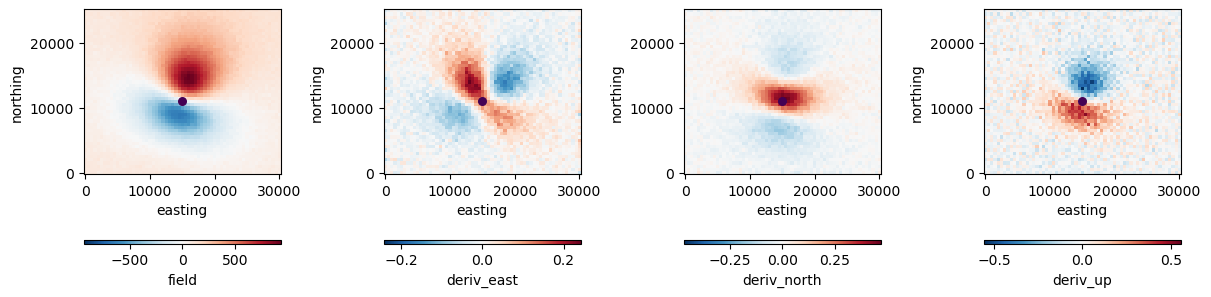

In [10]:
region = [0, 30e3, 0, 25e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Interfering source
# other = hm.dipole_magnetic(
#     coordinates, 
#     dipoles=(0e3, 0e3, -6e3),
#     magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
#     field="b",
# )
# magnetic_anomaly += sum(b * f for b, f in zip(other, main_field))

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

In [11]:
ed = euler.EulerDeconvolutionWindowed(structural_index=3, window_size=10e3, window_step=2.5e3)
ed.fit_grid(data)

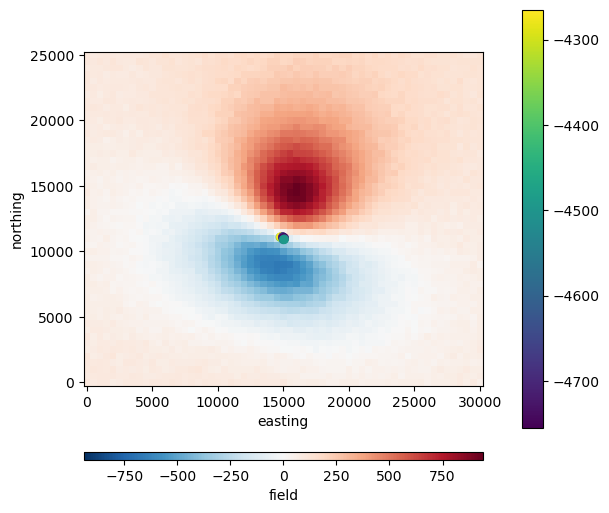

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout='constrained')
data.field.plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
tmp = ax.scatter(*ed.locations_[:2], c=ed.locations_[2], s=30)
fig.colorbar(tmp)
ax.set_aspect("equal")

In [13]:
%%time
ei = euler.EulerInversionWindowed(structural_index=3, window_size=10e3, window_step=2.5e3)
ei.fit_grid(data)

CPU times: user 13.2 s, sys: 0 ns, total: 13.2 s
Wall time: 13.2 s


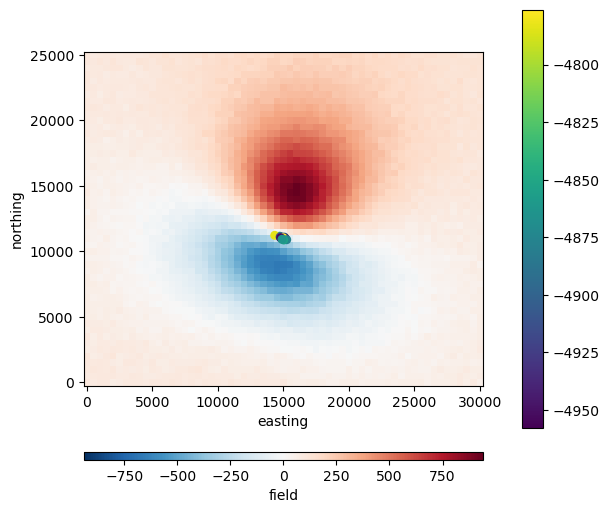

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout='constrained')
data.field.plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
tmp = ax.scatter(*ei.locations_[:2], c=ei.locations_[2], s=30)
fig.colorbar(tmp)
ax.set_aspect("equal")